<a href="https://colab.research.google.com/github/MathewBiddle/ioos_by_the_numbers/blob/main/IOOS_BTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating the IOOS By The Numbers

[Website](https://ioos.noaa.gov/about/ioos-by-the-numbers/)

[Spreadsheet](https://docs.google.com/spreadsheets/d/1AUfXmc3OwxpVdeMNjZyTGWjyR4ku3kRD5eexNrMORnI/edit#gid=516871794)

In [ ]:
import pandas as pd

# read previous metrics
ioos_btn_df = pd.read_csv('ioos_btn_metrics.csv')#columns=['category','value','date'])

In [ ]:
import pandas as pd
#today = pd.to_datetime
#ioos_btn_df = pd.DataFrame()#columns=['category','value','date'])

today = pd.Timestamp.strftime(pd.Timestamp.today(tz='UTC'), '%Y-%m-%d')

# only update numbers if it's a new day
if today not in ioos_btn_df['date_UTC'].to_list():
    ioos_btn_df = ioos_btn_df.append({'date_UTC': today}, ignore_index=True)

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-08,17.0,11.0,181.0,77318.0,762.0,517.0,4242.0,6.0,8.0,8.0,14.0,34.0,9455.0,1.0,5.0


## Federal Partners

ICOOS Act/COORA

In [ ]:
fed_partners = 17

# d = {'category':['Federal Partners'],'value':[fed_partners],'date':[today]}

# df_fed_part = pd.DataFrame(d)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Federal Partners']] = [fed_partners]

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-08,17.0,11.0,181.0,77318.0,762.0,517.0,4242.0,6.0,8.0,8.0,14.0,34.0,9455.0,1.0,5.0


## Regional Associations

In [ ]:
regional_associations = 11

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Regional Associations']] = [regional_associations]

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-08,17.0,11.0,181.0,77318.0,762.0,517.0,4242.0,6.0,8.0,8.0,14.0,34.0,9455.0,1.0,5.0


## Coastal & Ocean Modeling Testbed
Number of Active Projects - From Tracy.

In [ ]:
comt = 5

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['COMT Projects']] = comt

## HF Radar Installations

From http://hfrnet.ucsd.edu/sitediag/stationList.php

In [ ]:
url = 'http://hfrnet.ucsd.edu/sitediag/stationList.php?output=CSV'

df_hfr = pd.read_csv(url)

hfr_installations = df_hfr['Station'].unique().size

print('HF Radar Installations:',hfr_installations)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['HF Radar Stations']] = hfr_installations

HF Radar Installations: 181


## NGDAC Glider Days

From https://gliders.ioos.us/erddap/info/index.html?page=1&itemsPerPage=1000

Cumulative from 2008 - present

### Conditions on our calculations:
* drops all datasets with `datasetID` containing `delayed`.
* duration is calculated based on the metadata ERDDAP generates.
  * If a datum of `NaN` is in the `time` variable, the min/max will not be computed.

### Checks

[gist 1](https://nbviewer.org/urls/gist.githubusercontent.com/ocefpaf/e1e6f341c4149ff1d7b6541635d599fb/raw/f79b40741ed96672c025eaff9cbf87d7287b06f3/compute_gliders_days.ipynb)

This one fetches individual info dataset_ids URLs and matches what you are doing with allDatasets. It is still much bigger than `gdutils`, not sure what else it is filtering.

This is too slow (~20 mins), it only serves to double check this computation and to figure out how many gliders we are throwing away due to bad metadata, in this case, 1 `Nemesis-20170512T0000`. 

[gist 2](https://nbviewer.org/urls/gist.githubusercontent.com/ocefpaf/97b943abaa1490701cd386741fabeb56/raw/9628c27b678fbfd678c80195869112e64e32c5ad/compute_gliders_days-time-var.ipynb)

This one is a similar approach but with the time variable instead. We drop the NaN in the time var, so we do include most of `Nemesis-20170512T0000`. Note that it is larger, but not by much, than just the inclusion of `Nemesis-20170512T0000` and that is probably because the metadata is wrong in a few places. 

In theory the last one is more accurate but the difference is small.


In [14]:
import pandas as pd
df_glider = pd.read_csv('https://gliders.ioos.us/erddap/tabledap/allDatasets.csvp?minTime%2CmaxTime%2CdatasetID')
df_glider.dropna(
    axis=0, 
    inplace=True,
    )

# drop delayed datasets
df_glider = df_glider[df_glider["datasetID"].str.contains("delayed")==False]

df_glider[['minTime (UTC)','maxTime (UTC)']] = df_glider[
                                                         ['minTime (UTC)','maxTime (UTC)']
                                                         ].apply(pd.to_datetime)

df_glider['glider_days'] = (df_glider['maxTime (UTC)'] - df_glider['minTime (UTC)']).dt.days

glider_days = df_glider['glider_days'].sum()

print('Cumulative glider days:', glider_days)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['NGDAC Glider Days']] = glider_days

Cumulative glider days: 53654


In [16]:
# start_date = '2021-10-01'
# end_date = '2021-12-31'

# # find glider deployments between 10/01 and 12/31
# glider_day_within = df_glider.loc[
#     (df_glider['minTime (UTC)'] > pd.to_datetime(start_date,utc=True)) &
#     (df_glider['maxTime (UTC)'] < pd.to_datetime(end_date,utc=True))
# ]

# # gliders that start before 10/01 and end after 12/31
# glider_day_outside = df_glider.loc[
#     (df_glider['minTime (UTC)'] < pd.to_datetime(start_date,utc=True)) &
#     (df_glider['maxTime (UTC)'] > pd.to_datetime(end_date,utc=True))
# ]

# glider_day_outside.loc[:, 'maxTime (UTC)'] = pd.to_datetime(end_date, utc=True)
# glider_day_outside.loc[:, 'minTime (UTC)'] = pd.to_datetime(start_date, utc=True)

# # drop the ones from above as they will be duplicates in the next round of filtering
# df_glider.drop(axis=0, index=glider_day_outside.index, inplace=True)

# # Find gliders that start before 10/01 and end after 10/01
# glider_day_lower = df_glider.loc[
#     (df_glider['minTime (UTC)'] < pd.to_datetime(start_date,utc=True)) &
#     (df_glider['maxTime (UTC)'] > pd.to_datetime(start_date,utc=True))
# ]

# glider_day_lower.loc[:,'minTime (UTC)'] = pd.to_datetime(start_date, utc=True)

# # Find gliders that start before 12/31 and end after 12/31.
# glider_day_upper = df_glider.loc[
#     (df_glider['minTime (UTC)']<pd.to_datetime(end_date,utc=True)) &
#     (df_glider['maxTime (UTC)']>pd.to_datetime(end_date,utc=True))
# ]

# glider_day_upper.loc[:,'maxTime (UTC)'] = pd.to_datetime(end_date, utc=True)

# # Combine it all together into one DF.
# glider_subset = pd.concat([glider_day_lower, 
#                            glider_day_within, 
#                            glider_day_upper, 
#                            glider_day_outside], 
#                           verify_integrity=True)

# # Calculate the days between min time and max time.
# glider_subset['glider_days'] = (glider_subset['maxTime (UTC)'] - glider_subset['minTime (UTC)']).dt.days

# # Calculate total glider days.
# glider_subset['glider_days'].sum()

# print("Glider days between %s and %s: %s" % (start_date,end_date,glider_subset['glider_days'].sum()))

# National Platforms

### CO-OPS
* https://opendap.co-ops.nos.noaa.gov/stations/index.jsp
  * as xml: https://opendap.co-ops.nos.noaa.gov/stations/stationsXML.jsp
* https://tidesandcurrents.noaa.gov/cdata/StationList?type=Current+Data&filter=active

In [ ]:
#from lxml import etree
import requests

xml = requests.get('https://opendap.co-ops.nos.noaa.gov/stations/stationsXML.jsp').text
import re
COOPS = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape("station name"), xml))
print("All stations:",COOPS)

url = 'https://tidesandcurrents.noaa.gov/cdata/StationListFormat?type=Current+Data&filter=active&format=csv'

df_coops = pd.read_csv(url)
#print(df_coops[' Project'].unique())
ports = df_coops[df_coops[' Project'].astype(str).str.contains('PORTS')].shape[0]
print("Ports:", ports)

All stations: 379
Ports: 66


### NDBC
https://www.ndbc.noaa.gov/wstat.shtml	Buoys: 106 (103 base-funded); CMAN: 45

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pprint

url = 'https://www.ndbc.noaa.gov/wstat.shtml'

html = requests.get(url).text

soup = BeautifulSoup(html, 'html.parser')

string_to_find = ['Total Base Funded Buoys:','Total Other Buoys:',
                  'Total Moored Buoys:','Total Base Funded Stations:',
                  'Total Stations:']

ndbc = dict()
for string in string_to_find:
    for tag in soup.find_all("td", string=string):
        ndbc[string] = int(tag.next_sibling.string)

#pprint.pprint(ndbc)

NDBC = ndbc['Total Moored Buoys:'] + ndbc['Total Base Funded Stations:']
print('NDBC:',NDBC)

NDBC: 149


### NERRS
https://nosc.noaa.gov/OSC/OSN/index.php	NERRS SWMP; Across 29 NERRS; Source = internal access only - NOAA Observing System Council.

http://cdmo.baruch.sc.edu/webservices.cfm <- need IP address approval

Need number of stations (120 last time)

In [ ]:

import requests
from bs4 import BeautifulSoup
import re

url = 'https://coast.noaa.gov/nerrs/about/'

html = requests.get(url).text

soup = BeautifulSoup(html, 'html.parser')

string_to_find = ['The National Estuarine Research Reserve System is a network of ']

nerrs = dict()
for string in string_to_find:
  for tag in soup.find_all("meta", attrs={'content': re.compile(string)}, limit=1):
    res = [int(i) for i in tag['content'].split() if i.isdigit()] # extract number
    #print(tag['content'])
    NERRS = int(res[0])
    #print('%s = %s' % (string, tag.next_sibling.string))

NERRS = 140

print("NERRS reserves:",NERRS)


NERRS reserves: 140


### CBIBS
https://buoybay.noaa.gov/locations

[API docs](https://buoybay.noaa.gov/node/174)

Base URL: https://mw.buoybay.noaa.gov/api/v1

Testing Key: f159959c117f473477edbdf3245cc2a4831ac61f

Latest measurements:
https://mw.buoybay.noaa.gov/api/v1/json/station?key=f159959c117f473477edbdf3245cc2a4831ac61f

In [ ]:
import json

base_url = 'https://mw.buoybay.noaa.gov/api/v1'
apikey = 'f159959c117f473477edbdf3245cc2a4831ac61f'
start = '2021-12-08T01:00:00z'
end = '2021-12-09T23:59:59z'
var = 'Position'

query_url = '{}/json/query?key={}&sd={}&ed={}&var={}'.format(base_url,apikey,start,end,var)
#query_url = '{}/json/station?key={}'.format(base_url, apikey)

json = json.loads(requests.get(query_url).text)

CBIBS = len(json['stations'])

print("CBIBS Stations:",CBIBS)

CBIBS Stations: 10


### OAP
https://cdip.ucsd.edu/m/stn_table/	Includes overlap with the RAs and other programs

19

See buoys and moorings at https://oceanacidification.noaa.gov/WhatWeDo/Data.aspx

pull kml from pmel

In [ ]:
# import geopandas as gpd
# import fiona

# gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# kml = 'https://www.pmel.noaa.gov/co2/files/basekml.kml'

# df = gpd.read_file(kml, driver='KML')

# df['Name'].unique().size

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

url = 'https://oceanacidification.noaa.gov/WhatWeDo/Data.aspx'

#url = 'https://www.arcgis.com/apps/Embed/index.html?webmap=9512aae84cae409786339479e31b6c8a&amp;extent=-152.4023,-57.7072,146.7773,74.4006&amp;zoom=true&amp;scale=true&amp;disable_scroll=true&amp;theme=light'

html = requests.get(url).text

soup = BeautifulSoup(html, 'html.parser')

#string_to_find = ['The National Etuarine Research Reserve System is a network of ']
#soup.find_all(atts={'id':'mapDiv_gc'})
text = soup.find_all(attrs={'id':"dnn_ctr14711_ContentPane"})[0].find_all(attrs={'class':'lead'})[0].text #id="mapDiv")

res = [int(i) for i in text.split() if i.isdigit()] # extract number
    #print(tag['content'])
OAP = int(res[0])

print("OAP Stations:",OAP)

    #res = [int(i) for i in tag['content'].split() if i.isdigit()] # extract number
    #print(tag['content'])
    #nerrs = res[0]
    #print('%s = %s' % (string, tag.next_sibling.string))

#print("NERRS reserves:",nerrs)

OAP Stations: 19


### CDIP
https://cdip.ucsd.edu/m/stn_table/	Includes overlap with the RAs

67

https://cdip.ucsd.edu/themes/?d2=p1:m:mobile&regions=all&units=standard&zoom=auto&pub_set=public&tz=UTC&ll_fmt=dm&numcolorbands=10&palette=cdip_classic&high=6.096

In [ ]:
import lxml
import pandas as pd

url = 'https://cdip.ucsd.edu/themes/?d2=p1:m:mobile&regions=all&units=standard&zoom=auto&pub_set=public&tz=UTC&ll_fmt=dm&numcolorbands=10&palette=cdip_classic&high=6.096'
#url = 'https://cdip.ucsd.edu/m/stn_table/'
table_list = pd.read_html(url, match='Stn')

df = table_list[0]

CDIP = df['Stn'].unique().size

print("CDIP Stations:",CDIP)

CDIP Stations: 65


## Calculating National Platforms

CO-OPS + NDBC + NERRS + CBIBS + OAP + CDIP = 747

In [ ]:
national_platforms = COOPS + NDBC + NERRS + CBIBS + OAP + CDIP
print("National Platforms:",national_platforms)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['National Platforms']] = national_platforms

National Platforms: 762


# Regional Platforms

https://github.com/ioos/ioos-asset-inventory/tree/main/2020

http://erddap.ioos.us/erddap/tabledap/processed_asset_inventory.html

In [ ]:
url = 'http://erddap.ioos.us/erddap/tabledap/processed_asset_inventory.csvp'

df_regional_platforms = pd.read_csv(url)

regional_platforms = df_regional_platforms['station_long_name'].unique().size

print('Regional platforms:',regional_platforms)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Regional Platforms']] = regional_platforms

Regional platforms: 517


## ATN Deployments

See Deployments at https://portal.atn.ioos.us/#
Not sure if there is a way to scrape that page or get those values from somewhere

4242

In [ ]:
# from bs4 import BeautifulSoup
# import requests

# headers = {'Accept-Encoding': 'identity'}

# soup = BeautifulSoup(requests.get('https://portal.atn.ioos.us', headers=headers).text, 'html.parser')

# print(soup.prettify())

atn_deployments = 4444

print("ATN Deployments:",atn_deployments)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['ATN Deployments']] = atn_deployments

ATN Deployments: 4444


## MBON Projects
https://marinebon.org/

https://github.com/marinebon/www_marinebon2/tree/master/content/project

currently funded projects
6

In [ ]:
mbon_projects = 6

print("MBON Projects:",mbon_projects)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['MBON Projects']] = mbon_projects

MBON Projects: 6


## OTT Projects

https://ioos.noaa.gov/project/ocean-technology-transition/ 8 live

In [ ]:
ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['OTT Projects']] = 8

## HAB Pilot Projects

https://cdn.ioos.noaa.gov/media/2021/10/NHABON-Funding-Awards-FY21_v2.pdf
8 total

In [ ]:
ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['HAB Pilot Projects']] = 8

## QARTOD Manuals

https://ioos.noaa.gov/project/qartod/ 14?

In [ ]:
ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['QARTOD Manuals']] = 14

## IOOS Core Variables

https://www.iooc.us/task-teams/core-ioos-variables/

34

In [ ]:
ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['IOOS Core Variables']] = 34

## Metadata Records

previously 8,600

https://data.ioos.us/

In [ ]:
try:
  import owslib
except:
  %pip install owslib

In [ ]:
from owslib.csw import CatalogueServiceWeb

endpoint = "https://data.ioos.us/csw"

csw = CatalogueServiceWeb(endpoint, timeout=60)

csw.getdomain('GetRecords.resultType')

csw.results

csw.getrecords2()

records = csw.results['matches']

print("Found {} records from {}.".format(records,endpoint))
# for key, value in list(csw.records.items()):
#     print(u"[{}]\n{}\n".format(value.title, key))

Found 9241 records from https://data.ioos.us/csw.


In [ ]:
import pandas as pd

url = 'https://data.ioos.us/api/3/action/package_list'

mdf = pd.read_json(url)

metadata_records = len(mdf.result.unique())

print("Found {} records from {}.".format(metadata_records,url))

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Metadata Records']] = metadata_records

Found 9455 records from https://data.ioos.us/api/3/action/package_list.


## IOOS

In [ ]:
ioos = 1

print("IOOS:",ioos)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['IOOS']] = ioos

IOOS: 1


# Final IOOS by the Numbers table

In [ ]:
ioos_btn_df['date_UTC']=pd.to_datetime(ioos_btn_df['date_UTC'])

In [ ]:
ioos_btn_df.set_index('date_UTC')

,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
date_UTC,,,,,,,,,,,,,,,
2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
2022-04-08,17.0,11.0,181.0,77318.0,762.0,517.0,4444.0,6.0,8.0,8.0,14.0,34.0,9455.0,1.0,5.0


Overwrite existing csv with previous and new data.

In [ ]:
ioos_btn_df.to_csv('ioos_btn_metrics.csv', index=False)

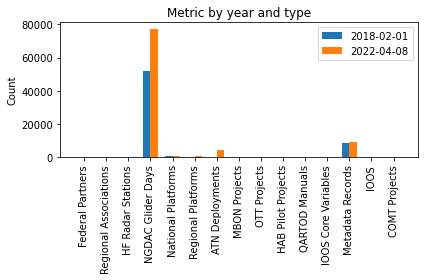

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ioos_btn_df.drop(columns=['date_UTC']).columns.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

for index, row in ioos_btn_df.iterrows():
  men_means = row.drop(index=['date_UTC']).values
  rects = ax.bar(x - width/2, men_means, width, label=row['date_UTC'].strftime('%Y-%m-%d'))
  width = width*-1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Metric by year and type')
ax.set_xticks(x, labels)
ax.legend()

ax.xaxis.set_ticklabels(labels, rotation=90)

fig.tight_layout()

plt.show()